# Sentence Embedding
Let's try embedding the headlines as an extra feature.

In [2]:
from util import get_wpm_train_test, get_label_columns

train_x_full, train_y, test_x, test_y, groups = get_wpm_train_test(include_groups=True, x_train_features_only=False)

features = get_label_columns() # initially only the manual labels

## Sample feature
Let's add the length of the headline as extra feature. The model can be found on [HuggingFace](https://huggingface.co/jegormeister/bert-base-dutch-cased-snli).

In [9]:
from sentence_transformers import SentenceTransformer

bertje = SentenceTransformer("jegormeister/bert-base-dutch-cased-snli")
bertje.encode("Wat een sprookjesverhaal, zijn we niet allemaal unicorns en dolfijnen?")[:5]

array([-0.55458266,  0.09503073, -0.31788656, -0.15507075,  0.12698768],
      dtype=float32)

In [19]:
import numpy as np
np.shape(bertje.encode(train_x_full["Headline"].head().tolist()))

(5, 768)

In [20]:
random_df = train_x_full.sample(n=5)[["Headline", "Lang"]]
random_df

,Headline,Lang
1352,Waarom 25 miljoen het strafste cijfer is van h...,1
1981,Staking bij Carrefour-winkels in Brugge en Bru...,0
381,Opvallend zicht bij modeshow: model trotseert ...,1
357,"Waarom je toch best een donsdeken kiest, zelfs...",0
73,Hoe raak ik in slaap? Mag ik thuisblijven? Kan...,1


Let's see how we can add the embedding to this dataframe:

In [22]:
# Add the sentence embedding of headline as extra feature (along with "Lang")
random_df[list(map(lambda i: f"Emb{i}", range(768)))] = bertje.encode(random_df["Headline"].tolist())
random_df.head()

C:\Users\arnod\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)


,Headline,Lang,Emb0,Emb1,Emb2,Emb3,Emb4,Emb5,Emb6,Emb7,...,Emb758,Emb759,Emb760,Emb761,Emb762,Emb763,Emb764,Emb765,Emb766,Emb767
1352,Waarom 25 miljoen het strafste cijfer is van h...,1,0.448517,0.278199,-0.420898,0.145133,0.690802,0.283390,0.939838,-0.180650,...,0.444060,6.597753,-1.051205,-0.426392,-0.275842,0.141099,-0.712734,-0.552485,1.015597,0.408669
1981,Staking bij Carrefour-winkels in Brugge en Bru...,0,0.942102,-0.463839,0.095217,0.519902,0.521845,-0.734484,0.155477,-1.265249,...,0.208803,6.282385,0.193626,-1.060673,0.305996,1.511493,-0.576653,0.800232,-0.826304,0.546866
381,Opvallend zicht bij modeshow: model trotseert ...,1,0.454693,0.516306,0.277446,0.632530,0.593025,-0.135509,0.381431,-0.619849,...,0.674591,6.123947,-0.339718,-0.694232,0.345503,0.705886,-0.535159,0.641356,0.171154,-0.483703
357,"Waarom je toch best een donsdeken kiest, zelfs...",0,-0.070716,-0.425522,-1.031793,0.662382,0.110643,-0.640449,0.808782,-0.147474,...,0.351059,6.178370,0.838096,-0.332504,0.244777,0.887251,-0.540983,-0.255850,-0.249933,0.110593
73,Hoe raak ik in slaap? Mag ik thuisblijven? Kan...,1,0.443153,0.556215,0.188518,0.301115,-0.004819,-0.256097,0.009731,0.231806,...,0.880076,6.366153,0.561849,-0.525922,-1.409188,0.644791,0.002090,-0.122780,0.314283,0.169879


Alright, seems like I've found a way to add the sentence embedding to the dataframe.

In [23]:
embedding_columns = list(map(lambda i: f"Emb{i}", range(768)))
features = features + embedding_columns
def add_headline_embedding_to_dataframe(df):
    modified_df = df.copy()
    modified_df[embedding_columns] = bertje.encode(df["Headline"].tolist())
    return modified_df

train_x_full_new = add_headline_embedding_to_dataframe(train_x_full)
test_x_new = add_headline_embedding_to_dataframe(test_x)

C:\Users\arnod\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)


Note: There probably must be a better way to do this, possibly with FeatureUnion, but that's also difficult to get to work, since FeatureUnion doesn't like the other parameters in a dataframe.

### Evaluate

In [26]:
from util import get_naive_bayes_model_wp, fit_predict_print_wp, print_wp_evaluation, predict_wp

model = get_naive_bayes_model_wp()

model.fit(train_x_full_new[features], train_y["Winner"])
predicted_winners = predict_wp(model, test_x_new, features=features)
print_wp_evaluation(predicted_winners, test_y)

Accuracy: 52.20% (95/182)


In [31]:
from util import get_xgboost_model_wp, fit_predict_print_wp, print_wp_evaluation, predict_wp

model = get_xgboost_model_wp()

model.fit(train_x_full_new[features], train_y["Winner"], groups)
predicted_winners = predict_wp(model, test_x_new, features=features)
print_wp_evaluation(predicted_winners, test_y)

C:\Users\arnod\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:525: FutureWarning: Pass `sample_weight` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(


Accuracy: 52.75% (96/182)


Strange, in both cases, this makes the model worse. Maybe we need to focus more on the difference between sentences.
Let's take a look at the importance of the features in xgboost:

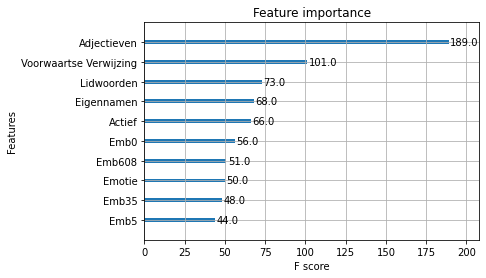

<Figure size 1152x864 with 0 Axes>

In [32]:
import xgboost as xgb
import matplotlib.pyplot as plt

xgb.plot_importance(model, max_num_features=10)
plt.figure(figsize=(16, 12))
plt.show()

Some of the embedding numbers are more important accoording to the model than other manually labelled features. It's also quite strange that the order of importance of the manually labelled features has completely changed. The previous top 3 was "Voorwaartse verwijzing", "Actief" and "Emotie". "Adjectieven" was only 9th. (but the model is worse than when only using the manual labels, so maybe I shouldn't trust the model).

Because of the bad performance, let's take a quick look whether the sentence embeddings are actually working for dutch by doing a similarity test. This code is strongly baased (almost copied) on the code from [this documentation](https://www.sbert.net/docs/quickstart.html#comparing-sentence-similarities).

In [29]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('jegormeister/bert-base-dutch-cased-snli')

sentences_original = ['A man is eating food.',
          'A man is eating a piece of bread.',
          'The girl is carrying a baby.',
          'A man is riding a horse.',
          'A woman is playing violin.',
          'Two men pushed carts through the woods.',
          'A man is riding a white horse on an enclosed ground.',
          'A monkey is playing drums.',
          'Someone in a gorilla costume is playing a set of drums.'
          ]

# Translated the sentences to dutch
sentences = ['Een man eet voedsel.',
             'Een man is een stuk brood aan het eten.',
             'Het meisje draagt een baby.',
             'Een man rijdt paard.',
             'Een vrouw is viool aan het spelen.',
             'Twee mannen duwen carts door het bos.',
             'Een man rijd op een wit paard in een afgesloten grond.',
             'Een aap speelt drum.',
             'Iemand in een gorilla kostuum speelt op een drumstel.']

#Encode all sentences
embeddings = model.encode(sentences)

#Compute cosine similarity between all pairs
cos_sim = util.cos_sim(embeddings, embeddings)

#Add all pairs to a list with their cosine similarity score
all_sentence_combinations = []
for i in range(len(cos_sim)-1):
    for j in range(i+1, len(cos_sim)):
        all_sentence_combinations.append([cos_sim[i][j], i, j])

#Sort list by the highest cosine similarity score
all_sentence_combinations = sorted(all_sentence_combinations, key=lambda x: x[0], reverse=True)

print("Top-5 most similar pairs:")
for score, i, j in all_sentence_combinations[0:5]:
    print("{} \t {} \t {:.4f}".format(sentences[i], sentences[j], cos_sim[i][j]))

Top-5 most similar pairs:
Een man eet voedsel. 	 Een man is een stuk brood aan het eten. 	 0.7251
Een man rijdt paard. 	 Een man rijd op een wit paard in een afgesloten grond. 	 0.7103
Een aap speelt drum. 	 Iemand in een gorilla kostuum speelt op een drumstel. 	 0.6851
Een vrouw is viool aan het spelen. 	 Iemand in een gorilla kostuum speelt op een drumstel. 	 0.3039
Het meisje draagt een baby. 	 Iemand in een gorilla kostuum speelt op een drumstel. 	 0.2685


Yup, the sentence embeddings seem to work. It's just not a useful feature in this scenario.